<a href="https://colab.research.google.com/github/Noy-Bo/Cancer-Cell-Segmentation/blob/master/Cancer_Cell_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Google Drive

mounting drive, setting root path to PanNuke dataset, setting device to cuda, checking out GPU


In [1]:

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
import os
root_path = '/content/gdrive/MyDrive/PanNuke' 
os.chdir(root_path)


In [3]:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cuda


In [4]:
!nvidia-smi

Wed Jul 21 06:42:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Dataset**
loading files, creating dataloaders, etc..



In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler

# VISUALIZING SAMPLES - designed for input that is the dataloader output, for raw input cancel moveaxis
def vis_sample(image, masks):
    fig, axs = plt.subplots(1,7)
    fig.set_size_inches(18.5, 3.2)
    fig.suptitle('Ground Truth', fontsize=18)
    #fig.tight_layout()
    axs[0].imshow(np.moveaxis(image.numpy().astype(np.uint8),0,-1)); axs[0].set_title("Sample")
    masks = np.moveaxis(masks.numpy().astype(np.uint8),0,-1)
    axs[1].imshow(masks[:,:,0], cmap="gray"); axs[1].set_title("Neoplastic cells")
    axs[2].imshow(masks[:,:,1], cmap="gray"); axs[2].set_title("Inflammatory")
    axs[3].imshow(masks[:,:,2], cmap="gray"); axs[3].set_title("Connective/Soft tissue cells")
    axs[4].imshow(masks[:,:,3], cmap="gray"); axs[4].set_title("Dead Cells")
    axs[5].imshow(masks[:,:,4], cmap="gray"); axs[5].set_title("Epithelial")
    axs[6].imshow(masks[:,:,5], cmap="gray"); axs[6].set_title("Background")
    plt.show()

# VISUALIZING PREDICTIONS - visualizing network output on a random sample.
def vis_predictions():
    image_gt_batch, masks_gt_batch = iter(training_loader_1).next()
    pred_masks_batch = model(image_gt_batch)
    for i in range(image_gt_batch.shape[0]): # looping on batch_size
      print("\n\n")
      print("\t\t\t\t\t\t\t\t SAMPLE: {}".format(str(i)))
      image = image_gt_batch[i,...] # 3,256,256
      pred_masks = pred_masks_batch[i,...] # 6,256,256

      fig, axs = plt.subplots(1,7)
      fig.set_size_inches(18.5, 3.3)
      fig.suptitle('Prediction', fontsize=18)
      #fig.tight_layout()
      axs[0].imshow(np.moveaxis(image.numpy().astype(np.uint8),0,-1)); axs[0].set_title("Sample")
      axs[1].imshow(pred_masks[0,:,:].cpu().detach().numpy(), cmap="gray"); axs[1].set_title("Neoplastic cells")
      axs[2].imshow(pred_masks[1,:,:].cpu().detach().numpy(), cmap="gray"); axs[2].set_title("Inflammatory")
      axs[3].imshow(pred_masks[2,:,:].cpu().detach().numpy(), cmap="gray"); axs[3].set_title("Connective/Soft tissue cells")
      axs[4].imshow(pred_masks[3,:,:].cpu().detach().numpy(), cmap="gray"); axs[4].set_title("Dead Cells")
      axs[5].imshow(pred_masks[4,:,:].cpu().detach().numpy(), cmap="gray"); axs[5].set_title("Epithelial")
      axs[6].imshow(pred_masks[5,:,:].cpu().detach().numpy(), cmap="gray"); axs[6].set_title("Background")
      plt.show()

      vis_sample(image,masks_gt_batch[i,...]) # visualizing gt (ground truth)


# LOADING DATASET
def load_dataset(dir_root, dir_images, dir_masks, training_size=0.8):

    train_set = PanNuke(dir_root, dir_images, dir_masks, train=True)

    # Splitting train into train/val
    permutations = torch.randperm(len(train_set))
    split = int(np.floor(training_size * len(train_set)))
    training_subset = SubsetRandomSampler(permutations[:split])
    validation_subset = SubsetRandomSampler(permutations[split:])

    # Apply DataLoader over train val and test data
    train_loader = DataLoader(train_set, sampler=training_subset, batch_size=12, num_workers=4)
    validation_loader = DataLoader(train_set, sampler=validation_subset, batch_size=12, num_workers=4)

    return train_loader, validation_loader



# DATASET CLASS
class PanNuke(Dataset):
    def __init__(self, dir_root, dir_images, dir_masks, val=False, train=False, test=False):
        self.images = np.load(dir_root+dir_images, mmap_mode='r')
        self.images = np.moveaxis(self.images, -1, 1)
        #self.images = np.copy(self.images)
        self.masks = np.load(dir_root+dir_masks, mmap_mode='r')
        self.masks = np.moveaxis(self.masks, -1, 1)
        #self.masks = np.copy(self.masks)

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img = np.copy(self.images[idx, ...])
        #masks = np.ceil(self.masks[idx, ...]/1000)
        masks = np.copy(self.masks[idx, ...])
        masks = np.ceil(masks/1000)
        return img, masks


# **Model**
basic UNet model configuration

In [6]:
from collections import OrderedDict

import torch
import torch.nn as nn


class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=54):
        super(UNet, self).__init__()

        features = init_features
        self.dropout = nn.Dropout2d()
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv_masks = nn.Conv2d(in_channels=features, out_channels=6, kernel_size=1)

        # self.conv = nn.Conv2d(
        #     in_channels=features, out_channels=out_channels, kernel_size=1
        # )


    def forward(self, x):
        x = x.to(device)
        enc1 = self.encoder1(x)
        enc1 = self.dropout(enc1)
        enc2 = self.encoder2(self.pool1(enc1))
        enc2 = self.dropout(enc2)
        enc3 = self.encoder3(self.pool2(enc2))
        enc3 = self.dropout(enc3)
        enc4 = self.encoder4(self.pool3(enc3))
        enc4 = self.dropout(enc4)

        bottleneck = self.bottleneck(self.pool4(enc4))
        bottleneck = self.dropout(bottleneck)

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec4 = self.dropout(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec3 = self.dropout(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec2 = self.dropout(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        dec1 = self.dropout(dec1)
        #return torch.sigmoid(self.conv(dec1))
        return torch.sigmoid(self.conv_masks(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

# **Train Utilities**
loss functions configurations, train epoch function ..


In [7]:
import sys
import torch.nn as nn
import torch
import tqdm

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

def dice_loss(predict, target):
    smooth = 1.
    loss = 0.
    for c in range(predict.shape[1]):
        iflat = predict[:, c, ...].contiguous().view(-1)
        tflat = target[:, c, ...].contiguous().view(-1)
        intersection = (iflat * tflat).sum()

        loss +=  (1 - ((2. * intersection + smooth) /
                          (iflat.sum() + tflat.sum() + smooth)))
    return loss

class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='sum'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        loss = 0
        for b_idx in range(predict.shape[0]):
            for m_idx in range(predict.shape[1]):
                predict_i = predict[b_idx,m_idx,...].contiguous().view(-1)
                target_i = target[b_idx,m_idx,...].contiguous().view(-1)

                num = torch.sum(torch.mul(predict_i, target_i), dim=0) + self.smooth
                den = torch.sum(predict_i.pow(self.p) + target_i.pow(self.p), dim=0) + self.smooth

                loss = loss +  1 - num / den

        # predict = predict.contiguous().view(predict.shape[0], -1)
        # target = target.contiguous().view(target.shape[0], -1)

        # num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        # den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth
        #
        # loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))


def train_epoch(training_loader, model, optimizer, loss_function):

    losses = []
    model.train()
    with tqdm.tqdm(total=len(training_loader), file=sys.stdout) as pbar:
        for idx_batch, (images, masks) in enumerate(training_loader, start=1):

            images = images.to(device)
            masks = masks.to(device)

            # calculate output
            y_hat = model(images)

            # calculate loss now:
            optimizer.zero_grad()
            loss = loss_function(y_hat, masks)
            loss.backward()

            # optimizing weights
            optimizer.step()

            # update loss bar
            losses.append(loss.detach())
            pbar.update();
            pbar.set_description(f'train loss={losses[-1]:.3f}')
        mean_loss = torch.mean(torch.FloatTensor(losses))
        pbar.set_description(f'train loss={mean_loss:.3f}')

        images = None
        masks = None
    return [mean_loss]

    
def eval_loss_epoch(training_loader, model, loss_function):

    losses = []
    model.eval()
    with tqdm.tqdm(total=len(training_loader), file=sys.stdout) as pbar:
        for idx_batch, (images, masks) in enumerate(training_loader, start=1):

            images = images.to(device)
            masks = masks.to(device)

            # calculate output
            y_hat = model(images)

            # calculate loss now:
            loss = loss_function(y_hat, masks)

            # optimizing weights

            # update loss bar
            losses.append(loss.detach())
            pbar.update();
            pbar.set_description(f'val loss={losses[-1]:.3f}')

            images = None
            masks = None
        mean_loss = torch.mean(torch.FloatTensor(losses))
        pbar.set_description(f'val loss={mean_loss:.3f}')

    return [mean_loss]


cuda


# **Main (training)**


In [ ]:
from torchsummary import summary
import torch
import torch.nn as nn

# creating data loaders
images_dir = 'Images 1/images.npy'
masks_dir = 'Masks 1/masks.npy'
training_loader_1, _ = load_dataset(dir_root='', dir_masks=masks_dir, dir_images=images_dir, training_size=1)
images_dir = 'Images 3/images.npy'
masks_dir = 'Masks 3/masks.npy'
training_loader_2, _ = load_dataset(dir_root='', dir_masks=masks_dir, dir_images=images_dir, training_size=1)
images_dir = 'Images 2/images.npy'
masks_dir = 'Masks 2/masks.npy'
validation_loader, test_loader = load_dataset(dir_root='', dir_masks=masks_dir, dir_images=images_dir, training_size=0.5)

# creating model
model = UNet().to(device)
summary(model, (3,256,256))
model.double()
# PATH = root_path + "/model_UNet.pt"
# model = torch.load(PATH)

# # visualization sample              # save every RAM we have!
# image, masks = iter(training_loader_1).next()
# vis_sample(image[0,...], masks[0,...])

# config training
epochs = 30
loss_function = dice_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9,0.999), eps =1e-08)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.9)

# training
for i in range (1,epochs):
 print("=========================== EPOCH: {} ===========================".format(str(i)))
 print("TRAIN LOSS:")
 train_epoch(training_loader=training_loader_1, model=model, optimizer=optimizer, loss_function=loss_function)
 train_epoch(training_loader=training_loader_2, model=model, optimizer=optimizer, loss_function=loss_function)
 print("VAL LOSS:")
 eval_loss_epoch(training_loader=validation_loader, model=model, loss_function=loss_function)
 scheduler.step()

# saving model
PATH = root_path + "/model_UNet.pt"
torch.save(model, PATH)

# loading model
model = UNet().to(device)
model = torch.load(PATH)

# visualizing predictions
vis_predictions()

print("END")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 54, 256, 256]           1,458
       BatchNorm2d-2         [-1, 54, 256, 256]             108
              ReLU-3         [-1, 54, 256, 256]               0
            Conv2d-4         [-1, 54, 256, 256]          26,244
       BatchNorm2d-5         [-1, 54, 256, 256]             108
              ReLU-6         [-1, 54, 256, 256]               0
         Dropout2d-7         [-1, 54, 256, 256]               0
         MaxPool2d-8         [-1, 54, 128, 128]               0
            Conv2d-9        [-1, 108, 128, 128]          52,488
      BatchNorm2d-10        [-1, 108, 128, 128]             216
             ReLU-11        [-1, 108, 128, 128]               0
           Conv2d-12        [-1, 108, 128, 128]         104,976
      BatchNorm2d-13        [-1, 108, 128, 128]             216
             ReLU-14        [-1, 108, 1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train loss=3.999: 100%|██████████| 227/227 [22:42<00:00,  6.00s/it]
VAL LOSS:
val loss=3.853: 100%|██████████| 106/106 [07:39<00:00,  4.33s/it]
=========================== EPOCH: 2 ===========================
TRAIN LOSS:
train loss=3.813: 100%|██████████| 227/227 [20:44<00:00,  5.48s/it]
VAL LOSS:
val loss=3.716: 100%|██████████| 106/106 [05:24<00:00,  3.06s/it]
=========================== EPOCH: 3 ===========================
TRAIN LOSS:
train loss=4.017:  23%|██▎       | 52/222 [04:43<15:30,  5.47s/it]

# **Visualizing Predictions vs Ground Truth**

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))





								 SAMPLE: 0


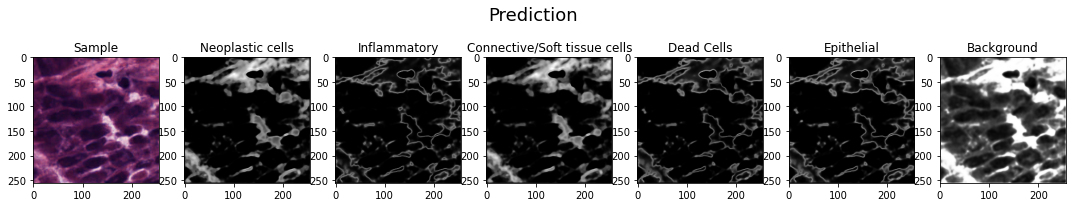

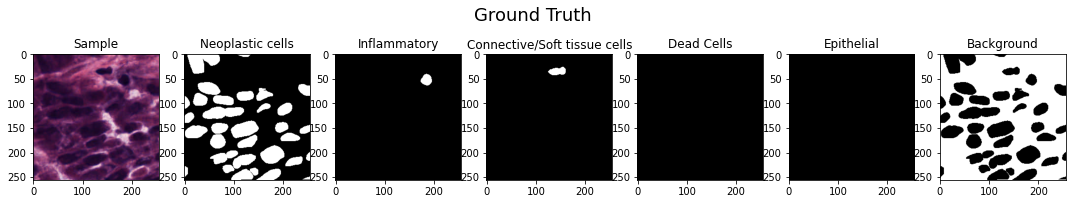




								 SAMPLE: 1


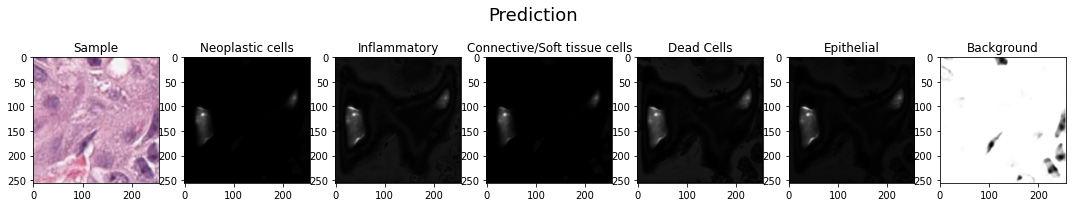

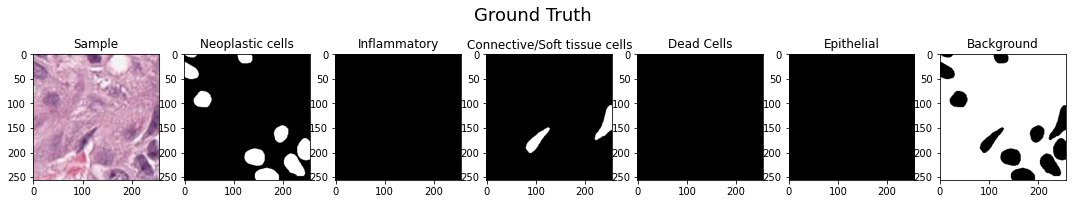




								 SAMPLE: 2


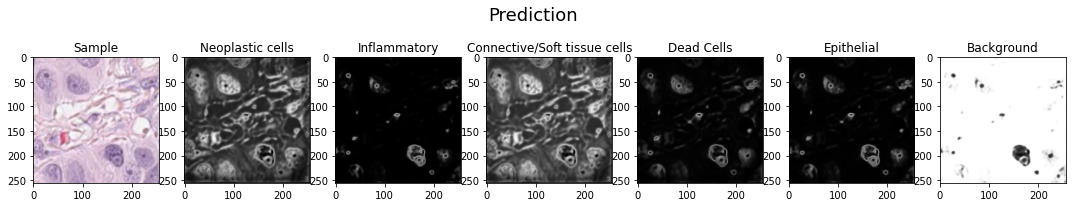

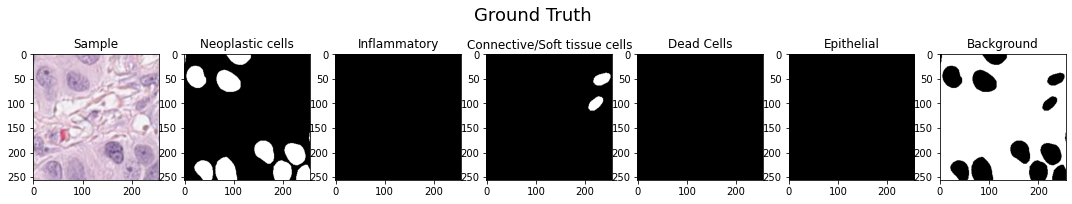




								 SAMPLE: 3


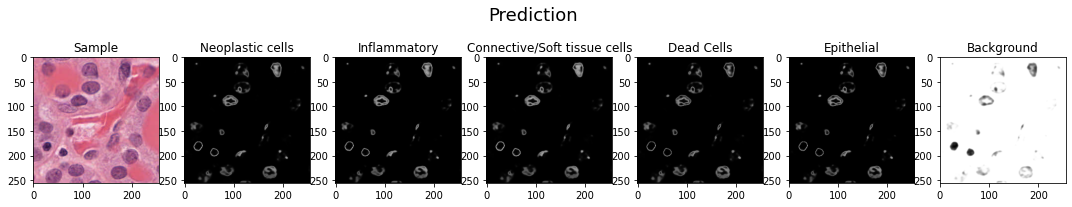

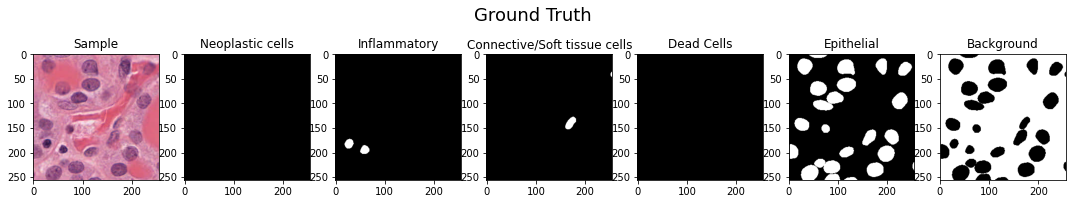




								 SAMPLE: 4


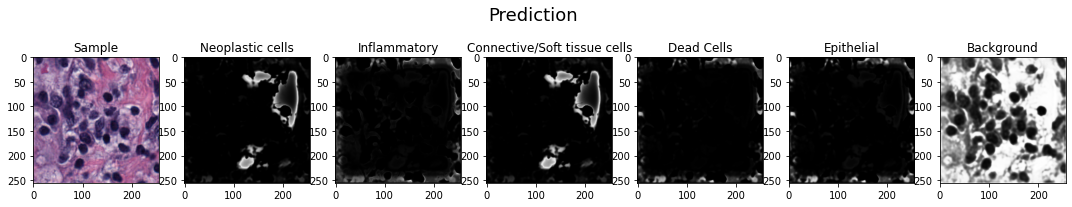

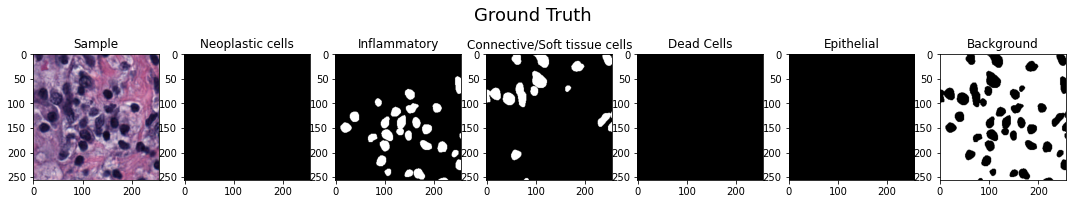




								 SAMPLE: 5


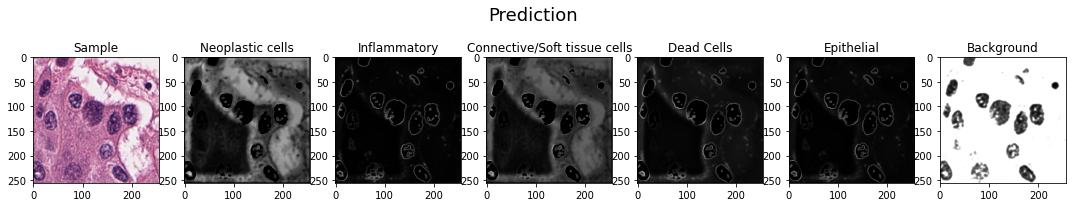

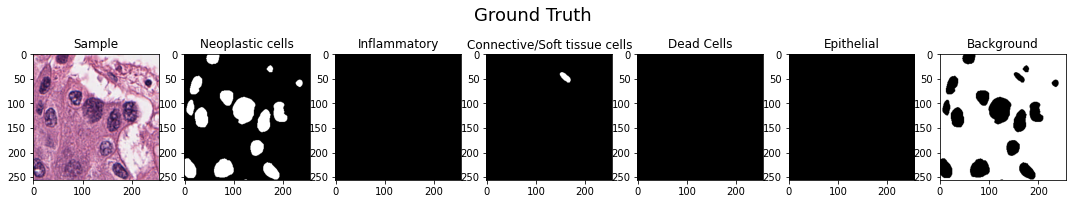




								 SAMPLE: 6


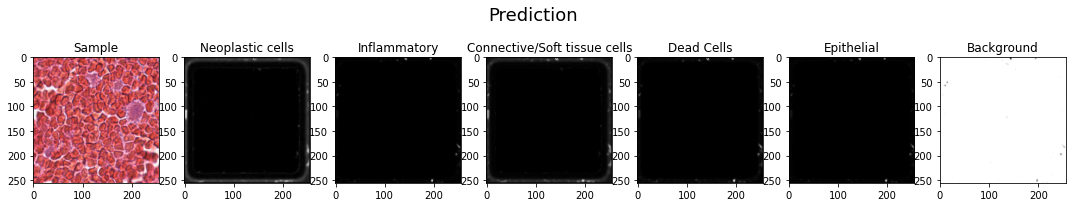

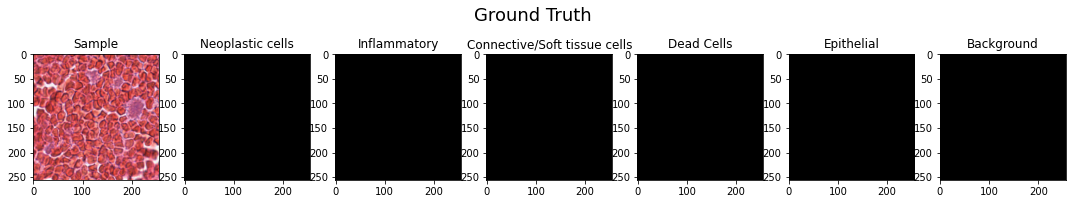




								 SAMPLE: 7


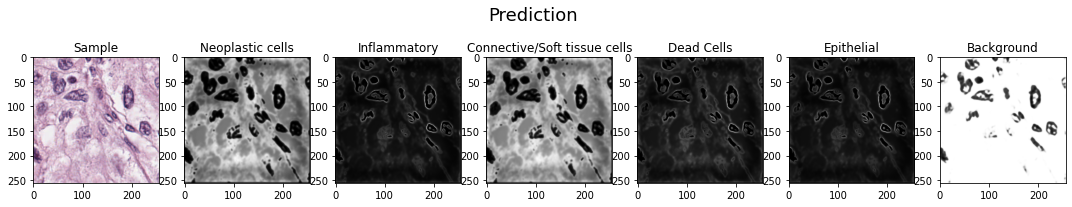

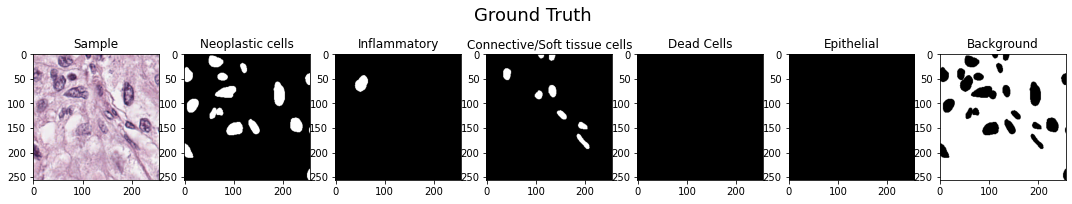

In [11]:
#saving model
PATH = root_path + "/model_UNet.pt"
torch.save(model, PATH)

# model = UNet().to(device)
# PATH = root_path + "/model_UNet.pt"
# model = torch.load(PATH)

vis_predictions()

In [22]:
torch.cuda.empty_cache()
